In [2]:
import numpy as np
import pandas as pd

# image manipulation
import cv2
import PIL
from PIL import Image

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# helpers
from tqdm import tqdm
import time

# for cnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset, WeightedRandomSampler,Subset

import torchvision
from torchvision import models
import torchvision.transforms as T
from sklearn import metrics as skm
from sklearn.metrics import classification_report, confusion_matrix

import copy

In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create custom dataset, inspect data classes distribution

Text(0.5, 0.98, 'Cancer distribution')

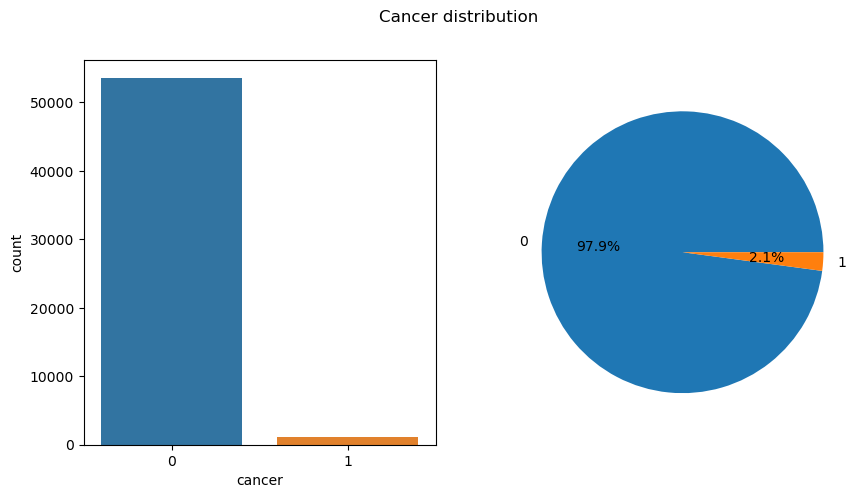

In [4]:
train_dir='/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut'
annotations='/kaggle/input/rsna-breast-cancer-detection/train.csv'
dftrain=pd.read_csv(annotations)
dftrain.head()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
########## PLOTING CANCER ################
splot = sns.countplot(ax = axes[0], x = dftrain['cancer'])

s = dftrain['cancer'].value_counts()
axes[1].pie(s, autopct="%.1f%%", labels = s.keys())
fig.suptitle('Cancer distribution')

In [5]:
# Create transformer or augmentor
augmentator = T.Compose([
    # input for augmentator is always PIL image
    # T.ToPILImage(),
    T.Resize((1024,1024)),
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.RandomRotation(5),
    #T.RandomResizedCrop(224),
    T.ToTensor()
])

In [6]:
class RSNAMamographyDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.df = pd.read_csv(annotations)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
        

    def __getitem__(self, ind):
        
        img_path = f"{self.img_dir}/{self.df.iloc[ind].patient_id}_{self.df.iloc[ind].image_id}.png"
        img = Image.open(img_path).convert('RGB')
        
        label = torch.tensor(self.df.iloc[ind].cancer).to(torch.float32)
        
        # there is no need to normalize data, it has already been normalized
        if self.transform:
            img = self.transform(img).to(torch.float32) 
        else:
            default_transform = T.Compose([T.ToTensor()])
            img = default_transform(img).to(torch.float32)
            
        #sample = {"image" : img, "label": label}
        return img, label

In [7]:
dataset = RSNAMamographyDataset(annotations, train_dir, augmentator)
len(dataset)

54706

In [8]:
# split into train set and validation set.
idx1=list(range(0, 20001))
idx2=list(range(20001,43765))
idx3=list(range(43765,len(dataset)-1))
trainSet1=Subset(dataset,idx1)
trainSet2=Subset(dataset,idx2)
valSet=Subset(dataset,idx3)
print(len(trainSet1),len(trainSet2),len(valSet))

20001 23764 10940


# Oversampling and downsampling dataloaders

In [9]:
class_counts = dftrain.cancer.value_counts()
class_counts

0    53548
1     1158
Name: cancer, dtype: int64

Now, that we have our class counts, we can calculate the weight for each class by taking the reciprocal of the count. This will ensure that classes with a higher representation will have a smaller weight.

In [10]:
sample_weights=[1. / torch.tensor(class_counts[i], dtype=torch.float) for i in dftrain.cancer.values]
sample_weights[:5]

[tensor(1.8675e-05),
 tensor(1.8675e-05),
 tensor(1.8675e-05),
 tensor(1.8675e-05),
 tensor(1.8675e-05)]

In [11]:
# split sample weights for training part
sample_weights1=sample_weights[:20001]
sample_weights2=sample_weights[20001:43765]
# pytorch weighted randomsampler probabilities
sampler1=WeightedRandomSampler(sample_weights1,len(sample_weights1),replacement=True)
sampler2=WeightedRandomSampler(sample_weights2,len(sample_weights2),replacement=True)

In [12]:
# create dataloaders, Applying random sampler just to train dataset.
batch_size = 32

train_loader1 = DataLoader(trainSet1, sampler=sampler1,batch_size=batch_size, pin_memory = True)
train_loader2 = DataLoader(trainSet2, sampler=sampler2,batch_size=batch_size, pin_memory = True)

val_loader = DataLoader(valSet, batch_size=batch_size, shuffle = True, pin_memory = True)
print(len(train_loader1),len(train_loader2),len(val_loader))

626 743 342


# Inspect one batch

torch.Size([32, 3, 1024, 1024]) torch.Size([32])
There are 14.0 negative and 18.0 positive samples in this batch.


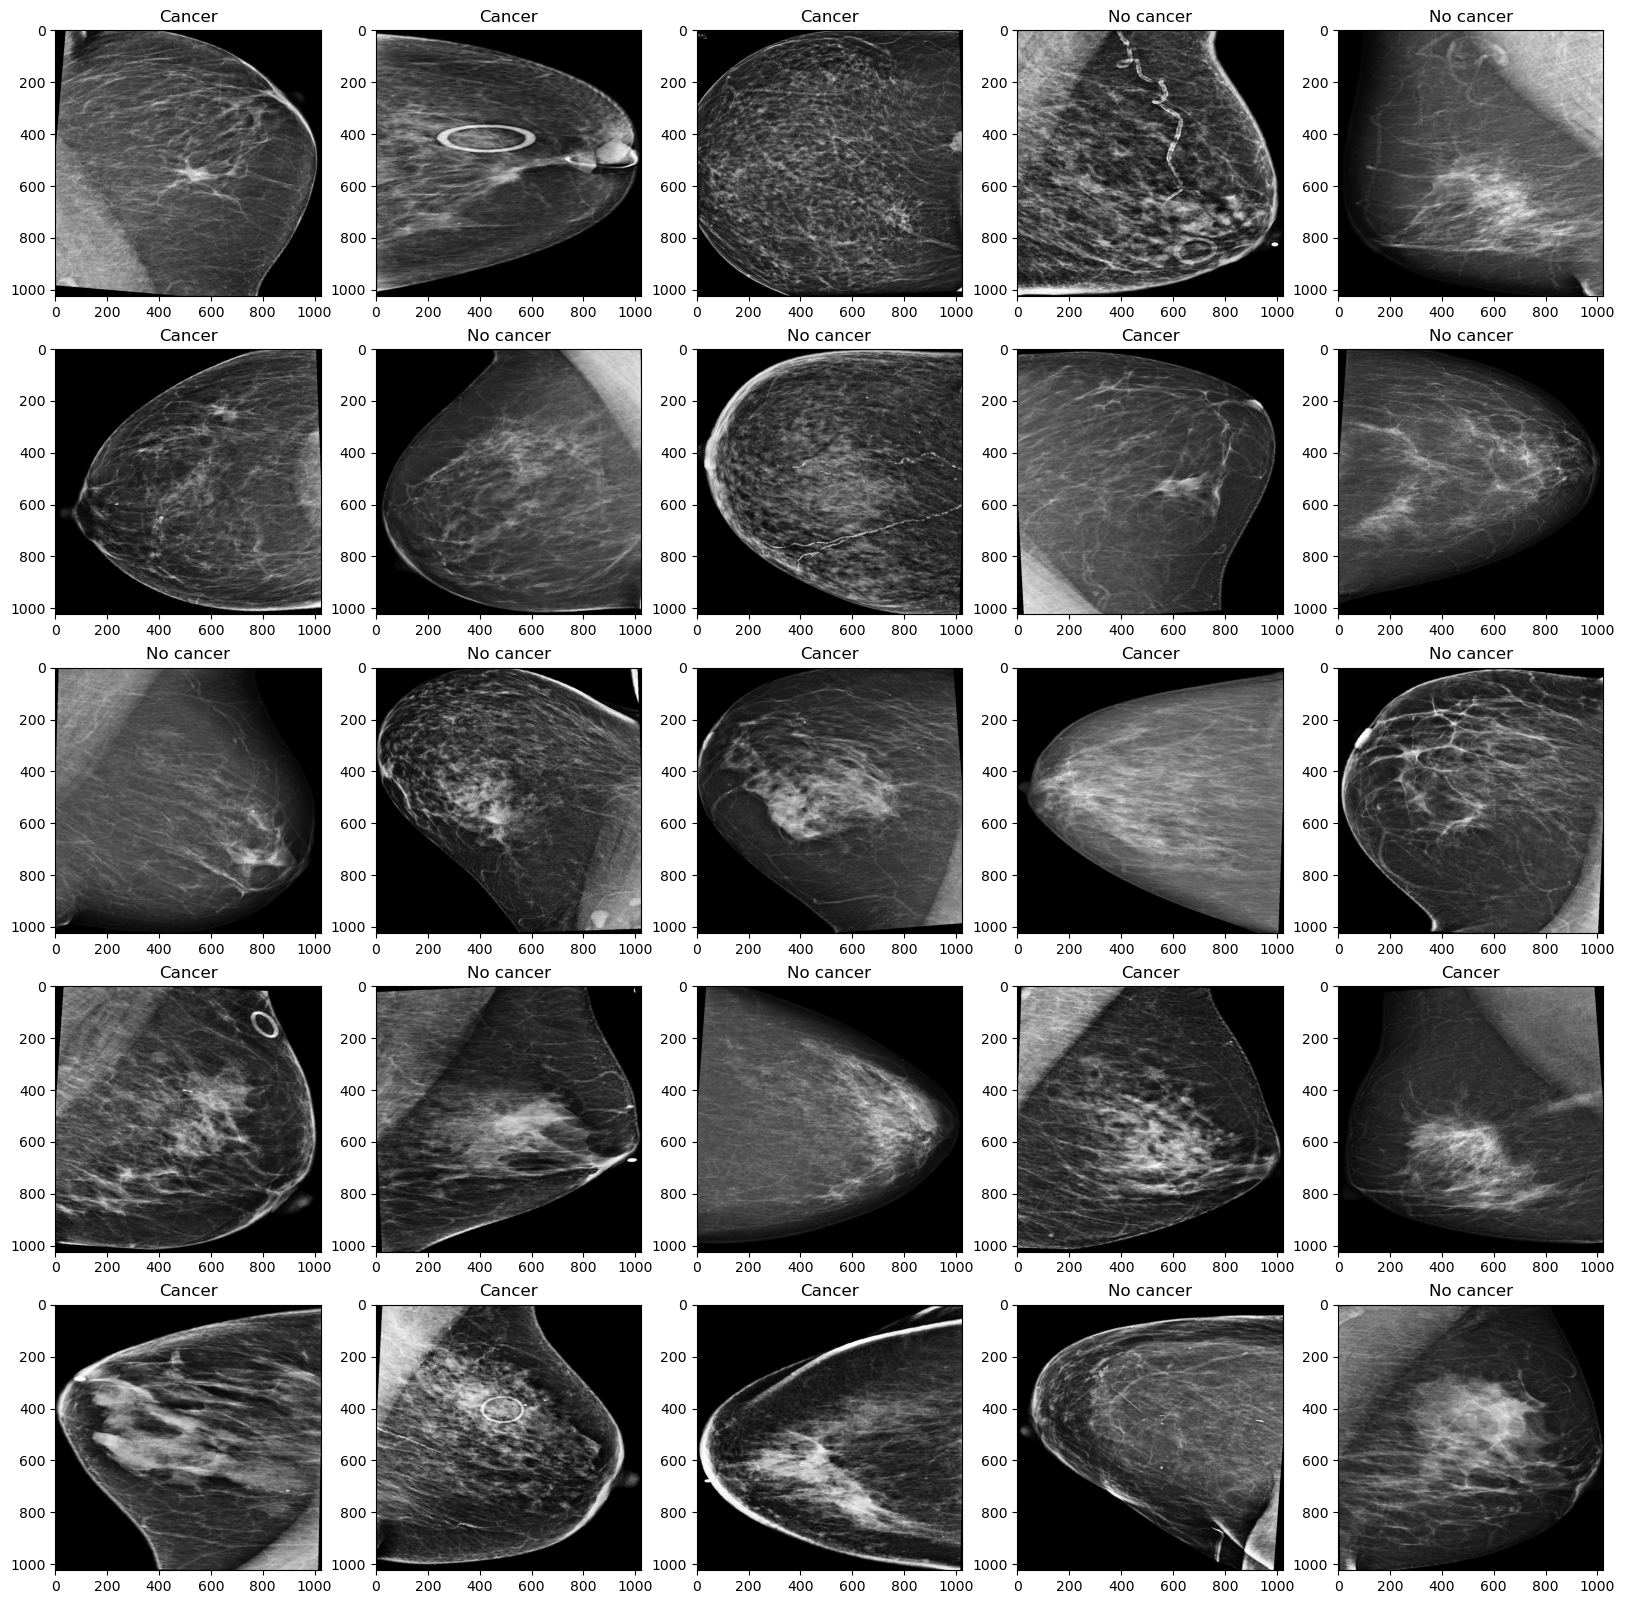

In [13]:
# inspect some images
rows = 5
cols = 5
plt.subplots(rows, cols, figsize = (20, 20))

batch_imgs, batch_labels = next(iter(train_loader1))
i = 0
for img in batch_imgs:
    if i >= rows*cols:
        break
    plt.subplot(rows, cols, i + 1)
    plt.title("Cancer" if batch_labels[i] == 1 else "No cancer")
    img = batch_imgs.data[i].numpy().transpose((1,2,0))
    img = img-np.min(img) # undo normalization
    img = img/np.max(img)
    plt.imshow(img)

    i += 1

print(batch_imgs.shape, batch_labels.shape)

labels_count = np.zeros(2)
for l in batch_labels:
    labels_count[int(l)] += 1 
    
print(f'There are {labels_count[0]} negative and {labels_count[1]} positive samples in this batch.')

# Create the model

In [14]:
#download transfered resnet18
resnet=torchvision.models.resnet18( pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features,1)
resnet.to(device);
# load the resnet trained
resnet.load_state_dict(torch.load('/kaggle/input/submission/trainedModel2.pt'))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

# Competition metrics Pf1

In [15]:
import numpy as np

def pf1_score(y_true, y_pred, beta=1):
    """Compute the PF1 score given true and predicted labels."""
    # Compute prevalence of positive class
    P = np.mean(y_true)
    
    # Compute precision and recall
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    # Compute PF1 score
    numerator = (1 + beta**2) * precision * recall
    denominator = (beta**2 * precision) + recall * (1 - P)
    pf1_score = numerator / denominator
    
    return pf1_score,precision,recall

# Loss function-Focal Loss

In [16]:
# test the lossfun of focal loss for once
X,y=next(iter(train_loader1))
X=X.to(device)
y=y[:,None]
y=y.to(device)
yHat=resnet(X)
loss=torchvision.ops.sigmoid_focal_loss(yHat,y,.25,2,"mean")
loss

tensor(0.2653, device='cuda:0', grad_fn=<MeanBackward0>)

In [33]:
# test the lossfun of bcelogistic weighted 
labels_count = np.zeros(2)
for l in y:
    labels_count[int(l)] += 1 
print(labels_count)
labels_count=[labels_count[0]/32,labels_count[1]/32]
print(labels_count)
class_weights_batch=torch.tensor([1/labels_count[0],1/labels_count[1]])
class_weights_batch

[19. 13.]
[0.59375, 0.40625]


tensor([1.6842, 2.4615], dtype=torch.float64)

In [34]:
lossfun=nn.BCEWithLogitsLoss(weight=class_weights_batch)
loss_bce=lossfun(yHat,y)
loss_bce

RuntimeError: output with shape [32, 1] doesn't match the broadcast shape [32, 2]

# Fine tune the model

In [ ]:
theBestModel = {'Loss':.25, 'net':None}

In [ ]:
numepochs = 2

optimizer = torch.optim.Adam(resnet.parameters(),lr=0.001)

# initialize losses and best-models
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
train_matrics = torch.zeros((numepochs,4))
test_matrics  = torch.zeros((numepochs,4))

# loop over epochs
for epochi in range(numepochs):
    # loop over training data batches
    resnet.train() # switch to train mode
    batchLoss = []
    batchAcc = []
    batchPrecision = []
    batchRecall= []
    batchF1 = []

    for X,y in train_dataloader:
        # push data to GPU
        X = X.to(device)
        y = y[:,None]
        y = y.to(device)

        # forward pass and loss
        yHat = resnet(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracies from this batch
        yHat=yHat.detach().cpu()
        y=y.cpu()
        batchLoss.append(loss.item())
        batchAcc.append( skm.accuracy_score(y, yHat>0))
        batchPrecision.append(skm.precision_score(y, yHat>0,zero_division=1))
        batchRecall.append(skm.recall_score(y, yHat>0,zero_division=1))
        batchF1.append(skm.f1_score(y, yHat>0,zero_division=1))
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    train_matrics[epochi,0]  = 100*np.mean(batchAcc)
    train_matrics[epochi,1]  = 100*np.mean(batchPrecision)
    train_matrics[epochi,2]  = 100*np.mean(batchRecall)
    train_matrics[epochi,3]  = 100*np.mean(batchF1)



    #### test performance (here done in batches!)
    resnet.eval() # switch to test mode
 
    batchLoss = []
    batchAcc = []
    batchPrecision = []
    batchRecall= []
    batchF1 = []
    for X,y in val_dataloader:
        # push data to GPU
        X = X.to(device)
        y = y[:,None]
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = resnet(X)
            loss = lossfun(yHat,y)
    
        # loss and accuracy from this batch
        yHat=yHat.detach().cpu()
        y=y.cpu()
        batchLoss.append(loss.item())
        batchAcc.append( skm.accuracy_score(y, yHat>0))
        batchPrecision.append(skm.precision_score(y, yHat>0,zero_division=1))
        batchRecall.append(skm.recall_score(y, yHat>0,zero_division=1))
        batchF1.append(skm.f1_score(y, yHat>0,zero_division=1))
        # end of batch loop...
    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    test_matrics[epochi,0]  = 100*np.mean(batchAcc)
    test_matrics[epochi,1]  = 100*np.mean(batchPrecision)
    test_matrics[epochi,2]  = 100*np.mean(batchRecall)
    test_matrics[epochi,3]  = 100*np.mean(batchF1)

    if testLoss[epochi] < theBestModel['Loss']:
        best_models['net']=copy.deepcopy(resnet.state_dict())
        best_models['Loss']=testLoss[epochi].item()
    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. testLoss={testLoss[epochi]:.4f}. Test f1 score = {test_matrics[epochi,3]:.4f}%')


In [ ]:
resnet.load_state_dict(best_models['net'])